# Hillslope Scale Calibration Tutorial

This notebook outlines how to perform model calibration for a selected subset of REWs. It is assumed that the selected subset is a unique sub-watershed of the full model watershed. It is furthermore assumed that channel effects are not important at the scale of the sub-watershed, so that the model can be compared to streamflow data simply by up-scaling the hillslopes output. 

Two files are required for hillslope scale calibration:

1. A shapefile corresponding to the sub-basin to be calibrated must be stored in `raw_data/watershed_poly`. 
2. Streamflow data (in units of cm/day) stored in the `calibration_data` folder. This must be gapless, daily streamflow data spanning at least the time period from `spinup_date` to `stop_date`. 

Full model calibration including channel transport is overviewed in the [Network Scale Calibration Tutorial](./network_scale_calibration.ipynb). 

In [1]:
import os
import sys
from os.path import dirname
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))
import random
random.seed()
from vadoseZone import *
import glob
from groundwaterZone import *
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from datetime import date
import pandas as pd
import numpy as np
import geopandas as gp
import mpld3
import time
import sys
import copy
import shapely
import fiona
from pyDOE import *
import folium
from ast import literal_eval as make_tuple
import hillslope_calibration
import multiprocessing as mp
%matplotlib inline

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir, 'StreamflowTempModel', '1_data_preparation'))
from prep import rew_params
rew_params()

rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
parameter_group_params = pickle.load( open( os.path.join(parent_dir,'model_data','parameter_group_params.p'), "rb" ))
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
parameter_ranges = pickle.load( open( os.path.join(parent_dir, 'model_data', 'parameter_ranges.p'), 'rb'))
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_hillslope']
t = model_config['t_hillslope']
resample_freq_hillslope = model_config['resample_freq_hillslope']
timestamps_hillslope = model_config['timestamps_hillslope']

/Users/daviddralle/anaconda/envs/py2k_model/lib/python2.7/site-packages/osgeo/gdal.py:83: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


## Get REWs located within calibration sub-watershed 

Here, we use the representative REW points to determine which REWs are located within the sub-watershed that we are calibrating. We want to make sure to run the model only for the REWs that are relevant for calibration. If no REWs are contained within the sub-watershed, the REW in which the sub-watershed is located will be calibrated. 

In [2]:
subwatershed_name = 'elder'
groups_to_calibrate, ids_in_subwatershed = hillslope_calibration.get_groups_to_calibrate(subwatershed_name + str('.shp'))

REWs [1, 2, 3] are located within the calibration sub-watershed
The groups [(1, 0), (1, 1), (1, 2)] will be run for calibration purposes


## Monte Carlo procedure

The hillslope calibrator will perform a simple Monte Carlo calibration on any parameters found in the `parameter_ranges` dictionary loaded above.

FIX WORDING

Now, objective function must be minimized, no matter what. 

In [3]:
# Nash sutcliffe efficiency. Should be maximized for best fit. 
def objective_function(modeled, observed):
    inds = ((modeled != 0) & (observed != 0))
    if np.sum(modeled)<0.01:
        return -9999.0
    elif np.isnan(np.sum(modeled)):
        return -9999.0
    else:
        return 1-np.sum((observed.loc[inds]-modeled.loc[inds])**2)/np.sum((observed.loc[inds]-np.mean(observed.loc[inds]))**2)
minimize_objective_function = False


# # Log nash sutcliffe efficiency. Should be maximized for best fit. 
# def objective_function(modeled, observed):
#     inds = ((modeled != 0) & (observed != 0))
#     if np.sum(modeled)<0.01:
#         return -9999.0
#     elif np.isnan(np.sum(modeled)):
#         return -9999.0
#     else:
#         return 1-np.sum((np.log(observed.loc[inds])-np.log(modeled.loc[inds]))**2)/np.sum((np.log(observed.loc[inds])-np.mean(np.log(observed.loc[inds])))**2)
# minimize_objective_function = False


# # r^2. Should be maximized for best fit. 
# def objective_function(modeled, observed):
#     inds = ((modeled != 0) & (observed != 0))
#     if np.sum(modeled)<0.01:
#         return -9999.0
#     elif np.isnan(np.sum(modeled)):
#         return -9999.0
#     else:
#         sstotal = np.sum((observed.loc[inds] - np.mean(observed.loc[inds]))**2)
#         ssreg = np.sum((modeled.loc[inds] - np.mean(observed.loc[inds]))**2)
#         ssres = np.sum((observed.loc[inds] - modeled.loc[inds])**2)
#         return 1-ssres/sstotal
# minimize_objective_function = False

In [8]:
#specify the number of parameter sets to generate
N = 1000
cores = mp.cpu_count()
print('There are %s cores on this machine, \n%s model runs will be performed on each core'%(str(cores), str(N)))

There are 4 cores on this machine, 
1000 model runs will be performed on each core


In [ ]:
subwatershed_calibration_name = 'elder_runoff' + '.p'
calibration_data = pickle.load( open(os.path.join(parent_dir,'calibration_data',subwatershed_calibration_name)))
calibration_data = calibration_data[spinup_date:stop_date]

parameters_per_core = {}
arguments = []
for cpu in range(0,cores):
    parameters_per_core[cpu] = hillslope_calibration.generate_parameter_sets(N, parameter_group_params, parameter_ranges)
    arguments.append((subwatershed_calibration_name, groups_to_calibrate, ids_in_subwatershed, parameters_per_core[cpu], objective_function, minimize_objective_function, cpu))

pool = mp.Pool()

# results is a list of 3-tuples. Each 3-tuple includes, in order, 
# the best fit model run time series
# the objective function value of the best run, and the index of the best run 
# parameter set
results = pool.map(hillslope_calibration.calibrate, arguments)
cpu_objs = [results[i][1] for i in range(cores)]
if minimize_objective_function:
    cpu_best = np.argmax(cpu_objs)
else:
    cpu_best = np.argmin(cpu_objs)

best_index = results[cpu_best][2]
best_fit = results[cpu_best][0]
best_objective = results[cpu_best][1]

/Users/daviddralle/anaconda/envs/py2k_model/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:166: DeprecationWarning: Widget._keys_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _keys_default(self):
/Users/daviddralle/anaconda/envs/py2k_model/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:166: DeprecationWarning: Widget._keys_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _keys_default(self):
/Users/daviddralle/anaconda/envs/py2k_model/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:166: DeprecationWarning: Widget._keys_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _keys_default(self):
/Users/daviddralle/anaconda/envs/py2k_model/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:166: DeprecationWarning: Widget._keys_default is deprecated in traitlets 4.1: use @default decorator instead.
  def _keys_default(self):


In [6]:
print('With an objective function value of %0.2f, the best parameter set is:' % (np.max(best_objective)))
print(parameters_per_core[cpu_best][best_index])


With an objective function value of 0.78, the best parameter set is:
{1: {'storageGZ': 5.0, 'zrS': 157.6173071827715, 'zrR': 1623.9194205727363, 'res2': 1.0, 'emax': 0.5, 'res1': 1.0, 'gz': <class groundwaterZone.LinearToNonlinearReservoir at 0x109923328>, 'nR': 0.10728329190299846, 'b': 1.7770402477384981, 'discharge': 0, 'stR': 0.5335342084033201, 'stS': 0.4279818796644076, 'ET': 0, 'storageS': 0.0, 'nS': 0.3387286249207048, 'leakage': 0, 'a': 0.04334802505434821, 'k12': 0.11489076169910249, 'storageR': 0.0, 'f': 0.11976064409827539, 's0R': 0.3131107657193627, 's0S': 0.21278117783103118, 'sfc': 0.51, 'storageVZ': 0, 'k1': 0.479268123468342, 'vz': <class vadoseZone.SimpleRockMoistureZone at 0x1098f5f58>}}


## Model goodness of fit

Here, each model run is compared to calibration data using the objective function as defined above. The user must specify the pickled dataframe with calibration runoff data in units of cm/day. Calibration data must be available at least from `spinup_date` to `stop_date`. 

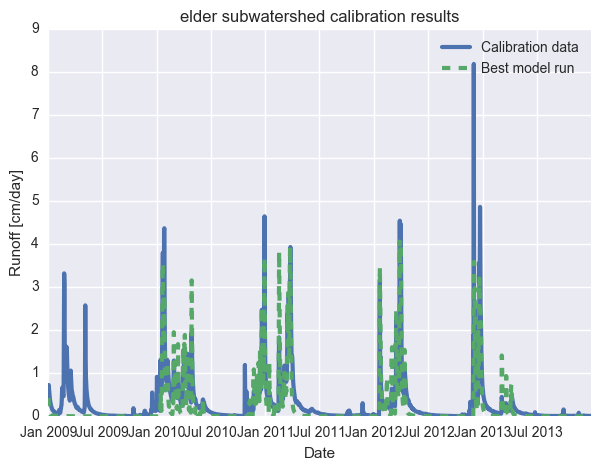

In [7]:
calibration_data = pickle.load( open(os.path.join(parent_dir,'calibration_data',subwatershed_calibration_name)))
sns.set(font_scale=1.0)
fig = plt.figure(figsize=(7,5))
plt.plot(calibration_data.loc[start_date:stop_date],linewidth=3)
plt.plot(best_fit.loc[start_date:stop_date],'--',linewidth=3)
plt.legend(['Calibration data', 'Best model run'])
plt.xlabel('Date')
plt.ylabel('Runoff [cm/day]')
plt.title( subwatershed_name + ' subwatershed calibration results')
html = mpld3.fig_to_html(fig)
#print 'The best fit parameter set has an objective function value of %0.2f' % (np.max(best_objective))
plt.savefig('/Users/daviddralle/Desktop/cal.pdf')

In [9]:
# Note: working in Folium, ALL projections must be converted to epsg='4326'
watershed_name = 'sf_below_tenmile'
subwatershed_name = 'elder'

#Add watershed
shapefile_path = os.path.join(parent_dir, 'raw_data','watershed_poly', watershed_name + '.shp')
basins_shape = gp.GeoDataFrame.from_file(shapefile_path).to_crs(epsg='4326')
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]
basins = basins_shape.to_crs(epsg='4326').to_json()
bounds = basins_shape.exterior.bounds

mapa = folium.Map([basins_shape['coords'][0][1], basins_shape['coords'][0][0]],
                  tiles='Stamen Terrain')

folium.GeoJson(
    basins,
    style_function=lambda feature: {
        'color' : '#00ff00',
        'fillOpacity': .05
        }
    ).add_to(mapa)


shapefile_path = os.path.join(parent_dir, 'raw_data','watershed_poly', subwatershed_name + '.shp')
basins_shape = gp.GeoDataFrame.from_file(shapefile_path).to_crs(epsg='4326')
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]
basins = basins_shape.to_crs(epsg='4326').to_json()

folium.GeoJson(
    basins,
    style_function=lambda feature: {
        'color' : '#FF0000',
        'opacity': 0.4
        }
    ).add_to(mapa)

iframe = folium.element.IFrame(html=html, width=650, height=400)
popup = folium.Popup(iframe, max_width=2650)
folium.Marker([basins_shape['coords'][0][1], basins_shape['coords'][0][0]], popup=popup, icon=folium.Icon(color='red',icon='info-sign')).add_to(mapa)

streams_path = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
streams_shape = gp.GeoDataFrame.from_file(streams_path).to_crs(epsg='4326')
streams = gp.GeoDataFrame(streams_shape['geometry'], crs=streams_shape.crs)
streams['RGBA'] = '#0000ff'
streams = streams.to_crs(epsg='4326').to_json()
colors = []
folium.GeoJson(
    streams,
    style_function=lambda feature: {
        'color' : feature['properties']['RGBA'],
        'weight' : 4, 
        'opacity': 1
        }
    ).add_to(mapa)


calibration_output_name = subwatershed_name + '_calibration.html'
mapa.fit_bounds([[ bounds['miny'].loc[0], bounds['minx'].loc[0]], [ bounds['maxy'].loc[0], bounds['maxx'].loc[0]]])
mapa.save(os.path.join(parent_dir, 'calibration_output', calibration_output_name))
mapa.save(os.path.join(calibration_output_name))
mapa